#                                                                          Introduction

## Business Context & Objective

Transport for London’s Vision Zero initiative sets an ambitious goal: to eliminate all deaths and serious injuries from London’s transport network by 2041 (Transport for London, 2023). Central to this vision is the use of data-driven strategies to enhance road safety and influence driver behaviour.

This project directly supports that mission by developing machine learning models for the Westminster, Croydon, Wandsworth, Southwark, and Lambeth local authorities, aimed at predicting the severity of traffic accidents based on driver behaviour, vehicle characteristics, and environmental conditions. By identifying high-risk scenarios and patterns, the models seek to promote safer driving practices and enable these boroughs to implement proactive, targeted safety measures.

The models are trained on validated 2023 accident data, as the 2024 dataset has not yet undergone full verification. Ultimately, this initiative contributes to a safer, smarter urban transport environment, in full alignment with Vision Zero’s long-term objectives.

## Model Consideration

#### This project will build the following models:
- SVM
- Random Forest
- Logistic Regression
- GBM

 Subsequently there performance will be compared against the baseline model and the top 2 best performing and practically suitable models will chosen to be implement as per the business use case mentioned above.

In [112]:
#Base Libraries
import numpy as np
import pandas as pd
import warnings
from scipy import stats
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)
import json
import gzip 
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict 
from IPython.display import display
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
!pip install scikit-optimize
!pip install xgboost
from xgboost import XGBClassifier
from datetime import timedelta
from timeit import default_timer as timer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import os
from joblib import dump
# create a folder where all trained models will be kept
if not os.path.exists("models"):
    os.makedirs("models")
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score



#Library for Plotting
import seaborn as sns
import matplotlib.pyplot as plt
 
#Library for Data Preprocessing and Cleaning
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import IsolationForest
 
 
#Prevent warnings of the code from showing
warnings.filterwarnings(action = 'ignore')


In [135]:
X_train = pd.read_csv('X_train 1.csv', index_col=0)
y_train = pd.read_csv('y_train 1.csv', index_col=0)
X_test = pd.read_csv('X_test 1.csv', index_col=0)
y_test = pd.read_csv('y_test 1.csv', index_col=0)

In [136]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

(7808, 165)
(7808, 1)
(1947, 165)
(1947, 1)


,accident_index,number_of_vehicles,number_of_casualties,speed_limit,age_of_driver,local_authority_ons_district_Lambeth,local_authority_ons_district_Southwark,local_authority_ons_district_Wandsworth,local_authority_ons_district_Westminster,road_type_One way street,...,casualty_type_Motorcycle over 125cc and up to 500cc rider or passenger,casualty_type_Motorcycle over 500cc rider or passenger,casualty_type_Other vehicle occupant,casualty_type_Pedestrian,casualty_type_Taxi/Private hire car occupant,casualty_type_Tram occupant,casualty_type_Van / Goods vehicle (3.5 tonnes mgw or under) occupant,month,hour,day_of_week
2142,2.023010e+12,1.098612,0.693147,3.433987,3.295837,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,19,1
1930,2.023010e+12,0.693147,0.693147,3.044522,3.714609,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,15,5
8757,2.023010e+12,1.098612,0.693147,3.433987,3.258097,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,17,5
9327,2.023010e+12,1.098612,0.693147,3.044522,4.174387,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,12,17,5
7125,2.023010e+12,1.098612,0.693147,3.044522,4.110874,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,18,2


In [137]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_columns = ['number_of_vehicles', 'number_of_casualties', 'speed_limit', 'age_of_driver']

scaled_vals = scaler.fit_transform(X_train[numerical_columns])
# Put the scaled values back into the original dataframe
X_train[numerical_columns] = scaled_vals


# Encode cyclical features
X_train['hour_sin'] = np.sin(2 * np.pi * X_train['hour'] / 24)
X_train['hour_cos'] = np.cos(2 * np.pi * X_train['hour'] / 24)
X_train['day_sin'] = np.sin(2 * np.pi * (X_train['day_of_week'] - 1) / 7)
X_train['day_cos'] = np.cos(2 * np.pi * (X_train['day_of_week'] - 1) / 7)
X_train['month_sin'] = np.sin(2 * np.pi * (X_train['month'] - 1) / 12)
X_train['month_cos'] = np.cos(2 * np.pi * (X_train['month'] - 1) / 12)
X_train = X_train.drop(columns=['hour', 'day_of_week', 'month'])

# inspect the data
X_train.head()

,accident_index,number_of_vehicles,number_of_casualties,speed_limit,age_of_driver,local_authority_ons_district_Lambeth,local_authority_ons_district_Southwark,local_authority_ons_district_Wandsworth,local_authority_ons_district_Westminster,road_type_One way street,...,casualty_type_Pedestrian,casualty_type_Taxi/Private hire car occupant,casualty_type_Tram occupant,casualty_type_Van / Goods vehicle (3.5 tonnes mgw or under) occupant,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
2142,2.023010e+12,0.116021,-0.312529,1.315487,-1.139575,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.965926,2.588190e-01,0.000000,1.000000,0.500000,0.866025
1930,2.023010e+12,-1.903348,-0.312529,-0.710615,0.228371,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.707107,-7.071068e-01,-0.433884,-0.900969,0.866025,0.500000
8757,2.023010e+12,0.116021,-0.312529,1.315487,-1.262856,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.965926,-2.588190e-01,-0.433884,-0.900969,-0.866025,0.500000
9327,2.023010e+12,0.116021,-0.312529,-0.710615,1.730264,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,-0.965926,-2.588190e-01,-0.433884,-0.900969,-0.500000,0.866025
7125,2.023010e+12,0.116021,-0.312529,-0.710615,1.522794,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.000000,-1.836970e-16,0.781831,0.623490,-0.866025,-0.500000


In [138]:
from sklearn.preprocessing import StandardScaler

# Assume 'scaler' is already fitted on X_train
numerical_columns = ['number_of_vehicles', 'number_of_casualties', 'speed_limit', 'age_of_driver']

# Apply the same transformation to X_test
scaled_vals = scaler.transform(X_test[numerical_columns])
X_test[numerical_columns] = scaled_vals

# Encode cyclical features
X_test['hour_sin'] = np.sin(2 * np.pi * X_test['hour'] / 24)
X_test['hour_cos'] = np.cos(2 * np.pi * X_test['hour'] / 24)
X_test['day_sin'] = np.sin(2 * np.pi * (X_test['day_of_week'] - 1) / 7)
X_test['day_cos'] = np.cos(2 * np.pi * (X_test['day_of_week'] - 1) / 7)
X_test['month_sin'] = np.sin(2 * np.pi * (X_test['month'] - 1) / 12)
X_test['month_cos'] = np.cos(2 * np.pi * (X_test['month'] - 1) / 12)

# Drop original cyclical columns
X_test = X_test.drop(columns=['hour', 'day_of_week', 'month'])



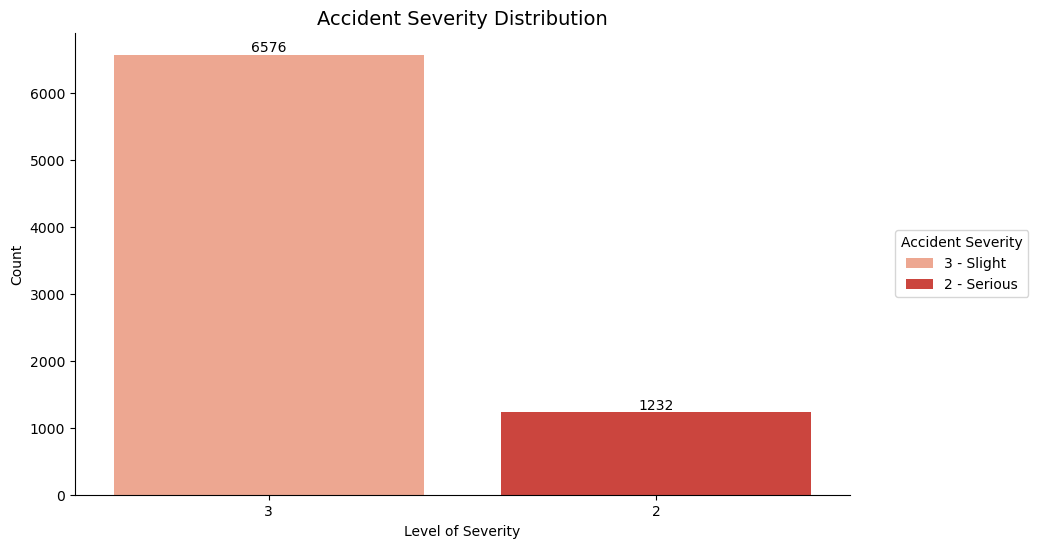

In [139]:
#Create a bar chart for the target variable.
plt.figure(figsize=(10, 6))
ax = sns.countplot(x =y_train['accident_severity'], order=y_train['accident_severity'].value_counts().index, palette='Reds')

#Add counts on bars
for container in ax.containers:
    ax.bar_label(container, fontsize=10)

#Label the plot and create a legend
plt.title('Accident Severity Distribution', fontsize=14)
plt.legend(title='Accident Severity', labels=['3 - Slight','2 - Serious'], bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.xlabel('Level of Severity')
plt.ylabel('Count')
plt.xticks(ha='center')

#Cleaner borders
sns.despine()
plt.show()

From the above graph it is evident there is a case of imbalanced data, that Accident Severity Level 3 ("Slight") has significantly more instances (6,590) compared to Severity Level 2 ("Serious") with only 1,218 occurrences. This can lead to Biased Model Predictions & Poor Performance on Minority Class, which will be addressed shortly.

In [140]:
X_train.head()

,accident_index,number_of_vehicles,number_of_casualties,speed_limit,age_of_driver,local_authority_ons_district_Lambeth,local_authority_ons_district_Southwark,local_authority_ons_district_Wandsworth,local_authority_ons_district_Westminster,road_type_One way street,...,casualty_type_Pedestrian,casualty_type_Taxi/Private hire car occupant,casualty_type_Tram occupant,casualty_type_Van / Goods vehicle (3.5 tonnes mgw or under) occupant,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
2142,2.023010e+12,0.116021,-0.312529,1.315487,-1.139575,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.965926,2.588190e-01,0.000000,1.000000,0.500000,0.866025
1930,2.023010e+12,-1.903348,-0.312529,-0.710615,0.228371,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.707107,-7.071068e-01,-0.433884,-0.900969,0.866025,0.500000
8757,2.023010e+12,0.116021,-0.312529,1.315487,-1.262856,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.965926,-2.588190e-01,-0.433884,-0.900969,-0.866025,0.500000
9327,2.023010e+12,0.116021,-0.312529,-0.710615,1.730264,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,-0.965926,-2.588190e-01,-0.433884,-0.900969,-0.500000,0.866025
7125,2.023010e+12,0.116021,-0.312529,-0.710615,1.522794,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.000000,-1.836970e-16,0.781831,0.623490,-0.866025,-0.500000


In [141]:
# Evaluates a trained model by printing classification metrics on the provided test data
def evaluate_model(model, ytest, Xtest):

    yhat = model.predict(Xtest)
    print(classification_report(ytest, yhat, zero_division=0))


# Displays a formatted summary table of cross-validation results from any search object
def print_cv_results(search_obj, col_width=100, max_rows=15):

    results = pd.DataFrame(search_obj.cv_results_)[
        ['params', 'mean_train_score', 'mean_test_score']
    ]
    results["diff, %"] = 100 * (
        results["mean_train_score"] - results["mean_test_score"]
    ) / results["mean_train_score"]

    # Display formatting
    pd.set_option('display.max_colwidth', col_width)
    pd.set_option('display.min_rows', max_rows)
    pd.set_option('display.max_rows', max_rows)

    display(results.sort_values('mean_test_score', ascending=False))

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curves(model, X, y, scoring='f1_macro', cv=10, train_sizes=np.linspace(0.1, 1.0, 5), save_path=None):
    """
    Plots learning curves with F1 Macro score for a classification model.

    Parameters:
    - model: fitted estimator or pipeline
    - X, y: training data
    - scoring: metric to evaluate (default = 'f1_macro')
    - cv: number of cross-validation folds
    - train_sizes: fractions of training set to use
    - save_path: if provided, saves the plot to this path
    """
    # Auto-generate model name for title
    try:
        model_name = type(model.named_steps[list(model.named_steps.keys())[-1]]).__name__
    except AttributeError:
        model_name = type(model).__name__

    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y,
        train_sizes=train_sizes,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        shuffle=True,
        random_state=42
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, 'o-', label="Training score")
    plt.plot(train_sizes, val_mean, 'o-', label="Cross-validation score")

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)

    plt.title(f"Learning Curve - {model_name}")
    plt.xlabel("Training Set Size")
    plt.ylabel("F1 Macro Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.show()


In [143]:
# Returns cross-validated F1 Macro, Class 2 F1, and Accuracy for a given model
def get_model_metrics(estimator, X, y):
    """Returns key metrics for a fitted estimator using cross_val_predict."""
    y_pred = cross_val_predict(estimator, X, y, cv=10)
    report = classification_report(y, y_pred, output_dict=True, zero_division=0)

    return {
        "F1 Macro": round(report["macro avg"]["f1-score"], 2),
        "Class 2 F1": round(report["2"]["f1-score"], 2),
        "Accuracy": round(accuracy_score(y, y_pred), 2)
    }

# Model Building & Evaluation

## Baseline

In [144]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
yhat_train = dummy_clf.predict(X_train)

evaluate_model(dummy_clf, y_train, X_train)

              precision    recall  f1-score   support

           2       0.00      0.00      0.00      1232
           3       0.84      1.00      0.91      6576

    accuracy                           0.84      7808
   macro avg       0.42      0.50      0.46      7808
weighted avg       0.71      0.84      0.77      7808



## Random Forest (RF) Model

### RF Model 1 – Adjusting Class Weights (using class_weight) to Handle Class Imbalance

In [145]:
start = timer()
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {
        'n_estimators': [100, 200, 500],
        'max_depth': [5, 10, None],
        'class_weight': [None, 'balanced', {2: 3, 3: 1}]
    }
]

forest = RandomForestClassifier(random_state=7)

# Set up GridSearchCV
rf_grid_search = GridSearchCV(rf, param_grid,
                              cv=10,  # 10-fold cross-validation
                              scoring='f1_macro',
                              n_jobs=-1,  # Use all CPU cores
                              return_train_score=True)

rf_grid_search.fit(X_train, y_train)
print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))


Execution time HH:MM:SS: 0:03:27.752029


In [146]:
# Display cross-validation results for each parameter combination
print_cv_results(rf_grid_search, col_width=100)

,params,mean_train_score,mean_test_score,"diff, %"
21,"{'class_weight': {2: 3, 3: 1}, 'max_depth': 10, 'n_estimators': 100}",0.796174,0.606708,23.797167
23,"{'class_weight': {2: 3, 3: 1}, 'max_depth': 10, 'n_estimators': 500}",0.802678,0.604705,24.664119
22,"{'class_weight': {2: 3, 3: 1}, 'max_depth': 10, 'n_estimators': 200}",0.799805,0.604108,24.468141
14,"{'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 500}",0.649449,0.592521,8.765553
12,"{'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 100}",0.647891,0.592262,8.586266
19,"{'class_weight': {2: 3, 3: 1}, 'max_depth': 5, 'n_estimators': 200}",0.627311,0.590397,5.884429
18,"{'class_weight': {2: 3, 3: 1}, 'max_depth': 5, 'n_estimators': 100}",0.625589,0.590067,5.678223
...,...,...,...,...
11,"{'class_weight': 'balanced', 'max_depth': 5, 'n_estimators': 500}",0.518476,0.516179,0.442910
3,"{'class_weight': None, 'max_depth': 10, 'n_estimators': 100}",0.487489,0.463023,5.018782


In [147]:
# Results
print("Best Parameters:", rf_grid_search.best_params_)
print("Best F1 Macro Score:", rf_grid_search.best_score_)

# Cross-validated predictions
y_train_pred = cross_val_predict(rf_grid_search.best_estimator_, X_train, y_train, cv=10)

# Evaluation
print("\nCross-Validated Classification Report:")
print(classification_report(y_train, y_train_pred, zero_division=0))

Best Parameters: {'class_weight': {2: 3, 3: 1}, 'max_depth': 10, 'n_estimators': 100}
Best F1 Macro Score: 0.606707514265665

Cross-Validated Classification Report:
              precision    recall  f1-score   support

           2       0.40      0.26      0.32      1232
           3       0.87      0.93      0.90      6576

    accuracy                           0.82      7808
   macro avg       0.64      0.59      0.61      7808
weighted avg       0.80      0.82      0.81      7808



The best Random Forest model with the tuned hyperparameters above showed a clear improvement over the baseline. It achieved a macro F1-score of just over 0.60, compared to 0.46 for the baseline model.

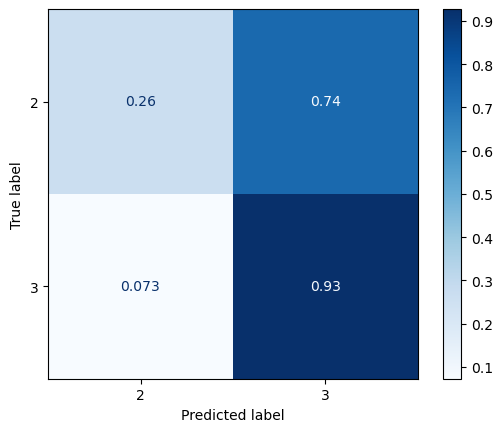

In [148]:
# cross-validation confusion matrix, training data
yhat = cross_val_predict(rf_grid_search.best_estimator_, X_train, y_train, cv=10)
ConfusionMatrixDisplay.from_predictions(y_train, yhat,
                                        labels=rf_grid_search.best_estimator_.classes_,
                                        normalize="true",
                                        cmap=plt.cm.Blues)

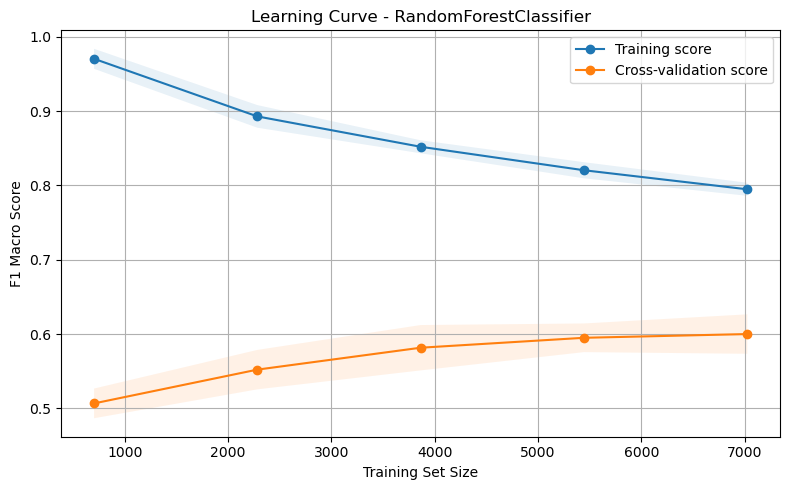

In [149]:
plot_learning_curves(rf_grid_search.best_estimator_, X_train, y_train)

### RF Model 2 - Oversampling the Minority Class (using SMOTE) To Handle Class Imbalance

As Undersampling can result in risk of underfitting and lose of useful information that could contribute to model generalization, we will be Oversampling the Minority Class using SMOTE (Synthetic Minority Over-sampling Technique).


In [150]:
start = timer ()
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=7)),
    ('rfc', RandomForestClassifier(random_state=7))
])

# Define the search space
param_dist = {
    'rfc__n_estimators': [100, 200, 500],
    'rfc__max_depth': [5, None],
    'smote__sampling_strategy': [0.5, 0.75, 1.0]
}

# Randomized search
os_random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=6,                         # Number of random combinations to try
    cv=10,
    scoring='f1_macro',
    return_train_score=True,
    random_state=42,
    n_jobs=-1
)

# Fit the model
os_random_search.fit(X_train, y_train)
print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Execution time HH:MM:SS: 0:00:47.390489


In [151]:
# Display cross-validation results for each parameter combination
print_cv_results(os_random_search, col_width=100)

,params,mean_train_score,mean_test_score,"diff, %"
2,"{'smote__sampling_strategy': 1.0, 'rfc__n_estimators': 500, 'rfc__max_depth': 5}",0.610542,0.594310,2.658551
3,"{'smote__sampling_strategy': 1.0, 'rfc__n_estimators': 200, 'rfc__max_depth': 5}",0.610469,0.592939,2.871518
1,"{'smote__sampling_strategy': 0.75, 'rfc__n_estimators': 100, 'rfc__max_depth': 5}",0.585947,0.568636,2.954459
5,"{'smote__sampling_strategy': 0.75, 'rfc__n_estimators': 200, 'rfc__max_depth': None}",1.000000,0.543291,45.670873
0,"{'smote__sampling_strategy': 0.5, 'rfc__n_estimators': 100, 'rfc__max_depth': 5}",0.499053,0.494496,0.913133
4,"{'smote__sampling_strategy': 0.5, 'rfc__n_estimators': 200, 'rfc__max_depth': 5}",0.500848,0.490209,2.124149


In [152]:
# Results
print("Best Parameters:", os_random_search.best_params_)
print("Best F1 Macro Score:", os_random_search.best_score_)

# Cross-validated predictions
y_train_pred = cross_val_predict(os_random_search.best_estimator_, X_train, y_train, cv=10)

# Evaluation
print("\nCross-Validated Classification Report:")
print(classification_report(y_train, y_train_pred, zero_division=0))

Best Parameters: {'smote__sampling_strategy': 1.0, 'rfc__n_estimators': 500, 'rfc__max_depth': 5}
Best F1 Macro Score: 0.5943099996659227

Cross-Validated Classification Report:
              precision    recall  f1-score   support

           2       0.29      0.31      0.30      1232
           3       0.87      0.86      0.86      6576

    accuracy                           0.77      7808
   macro avg       0.58      0.58      0.58      7808
weighted avg       0.78      0.77      0.78      7808



The best model identified through RandomizedSearchCV uses SMOTE with a sampling_strategy of 1.0. This means that during training, the minority class (label 2) was oversampled to have the same number of instances as the majority class (label 3).

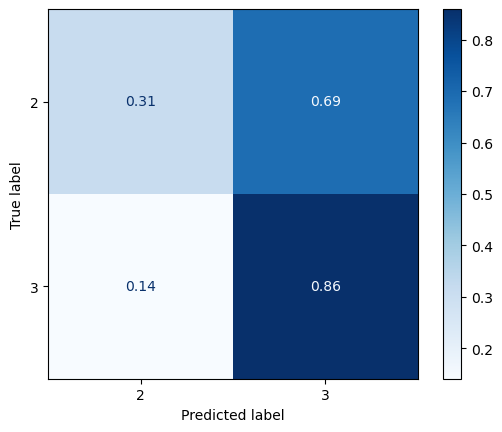

In [153]:
# cross-validation confusion matrix, training data
yhat = cross_val_predict(os_random_search.best_estimator_, X_train, y_train, cv=10)
ConfusionMatrixDisplay.from_predictions(y_train, yhat,
                                        labels=os_random_search.best_estimator_.classes_,
                                        normalize="true",
                                        cmap=plt.cm.Blues)

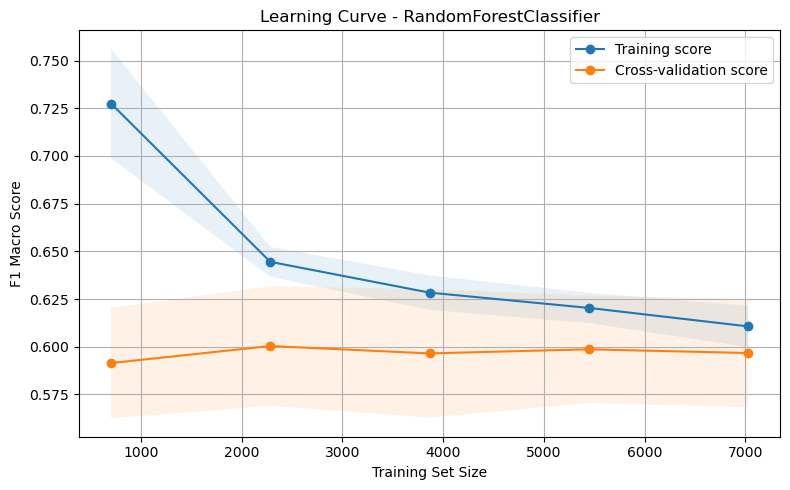

In [154]:
plot_learning_curves(os_random_search.best_estimator_, X_train, y_train)

In [155]:
# Get metrics for both models
model1_metrics = get_model_metrics(rf_grid_search.best_estimator_, X_train, y_train)
model2_metrics = get_model_metrics(os_random_search.best_estimator_, X_train, y_train)

# Create DataFrame 
df_compare = pd.DataFrame({
    "Random Forest without SMOTE": model1_metrics,
    "Random Forest with SMOTE": model2_metrics
})

# Display transposed table (metrics as rows)
df_compare

,Random Forest without SMOTE,Random Forest with SMOTE
F1 Macro,0.61,0.58
Class 2 F1,0.32,0.30
Accuracy,0.82,0.77


- Random Forest (RF) without SMOTE outperformed the SMOTE version on most metrics: Accuracy: 0.83 vs 0.77 & F1 Macro: 0.61 vs 0.59

- Class 2 F1-score was slightly better with SMOTE: 0.33 vs 0.31 (without SMOTE)

- SMOTE provided a small gain for minority class, but reduced overall accuracy.

Overall, The RF model with class weight handled class imbalance sufficiently well without oversampling, offering a better overall balance.

### Learning Curve results:
RF with SMOTE:
- Shows a smaller gap between training and validation scores, indicating less overfitting.

- Validation performance is slightly more stable and improves modestly with more data.

RF with class weight:
- Maintains a higher training score, but with a larger train-validation gap, suggesting more overfitting.

- Validation score improves slightly but plateaus earlier, showing limited generalisation.

While RF with SMOTE generalised slightly better, RF with class_weight was chosen due to its due to its higher overall accuracy and macro F1-score.

In [156]:
# Save the best estimator (final trained model) from RandomizedSearchCV
dump(rf_grid_search.best_estimator_, 'models/Random_Forest.joblib')

['models/Random_Forest.joblib']

## Decision Tree

### DT Model 2 - with Class Weight

In [157]:
start = timer()

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=7)

hp_grid = {
    'max_depth': [5, 10, 15, 20, 25, 30, 35, 40],
    'min_samples_split': [5, 10, 15, 20, 25, 30, 35],
    'class_weight': [{2: 3, 3: 1},{2: 2, 3: 1}, 'balanced', None],  # Using class weights
}

grid_search = GridSearchCV(dt, hp_grid, cv=10,
                           scoring='f1_macro',
                           return_train_score=True, verbose=2)

grid_search.fit(X_train, y_train)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Fitting 10 folds for each of 224 candidates, totalling 2240 fits
[CV] END class_weight={2: 3, 3: 1}, max_depth=5, min_samples_split=5; total time=   0.0s
[CV] END class_weight={2: 3, 3: 1}, max_depth=5, min_samples_split=5; total time=   0.0s
[CV] END class_weight={2: 3, 3: 1}, max_depth=5, min_samples_split=5; total time=   0.0s
[CV] END class_weight={2: 3, 3: 1}, max_depth=5, min_samples_split=5; total time=   0.0s
[CV] END class_weight={2: 3, 3: 1}, max_depth=5, min_samples_split=5; total time=   0.0s
[CV] END class_weight={2: 3, 3: 1}, max_depth=5, min_samples_split=5; total time=   0.0s
[CV] END class_weight={2: 3, 3: 1}, max_depth=5, min_samples_split=5; total time=   0.0s
[CV] END class_weight={2: 3, 3: 1}, max_depth=5, min_samples_split=5; total time=   0.0s
[CV] END class_weight={2: 3, 3: 1}, max_depth=5, min_samples_split=5; total time=   0.0s
[CV] END class_weight={2: 3, 3: 1}, max_depth=5, min_samples_split=5; total time=   0.0s
[CV] END class_weight={2: 3, 3: 1}, max_depth

In [158]:
# Display cross-validation results for each parameter combination
print_cv_results(grid_search, col_width=100)

,params,mean_train_score,mean_test_score,"diff, %"
98,"{'class_weight': {2: 2, 3: 1}, 'max_depth': 35, 'min_samples_split': 5}",0.963524,0.650433,32.494389
91,"{'class_weight': {2: 2, 3: 1}, 'max_depth': 30, 'min_samples_split': 5}",0.962295,0.650172,32.435271
105,"{'class_weight': {2: 2, 3: 1}, 'max_depth': 40, 'min_samples_split': 5}",0.963877,0.650120,32.551506
84,"{'class_weight': {2: 2, 3: 1}, 'max_depth': 25, 'min_samples_split': 5}",0.956255,0.650074,32.018805
49,"{'class_weight': {2: 3, 3: 1}, 'max_depth': 40, 'min_samples_split': 5}",0.959103,0.644398,32.812463
28,"{'class_weight': {2: 3, 3: 1}, 'max_depth': 25, 'min_samples_split': 5}",0.940100,0.643865,31.510962
42,"{'class_weight': {2: 3, 3: 1}, 'max_depth': 35, 'min_samples_split': 5}",0.958748,0.643860,32.843620
...,...,...,...,...
172,"{'class_weight': None, 'max_depth': 5, 'min_samples_split': 25}",0.513336,0.488099,4.916238
168,"{'class_weight': None, 'max_depth': 5, 'min_samples_split': 5}",0.516268,0.487549,5.562760


In [159]:
# Results
print("Best Parameters:",grid_search.best_params_)
print("Best F1 Macro Score:", grid_search.best_score_)

# Cross-validated predictions
y_train_pred = cross_val_predict(grid_search.best_estimator_, X_train, y_train, cv=10)

# Evaluation
print("\nCross-Validated Classification Report:")
print(classification_report(y_train, y_train_pred, zero_division=0))

Best Parameters: {'class_weight': {2: 2, 3: 1}, 'max_depth': 35, 'min_samples_split': 5}
Best F1 Macro Score: 0.6504328050310609

Cross-Validated Classification Report:
              precision    recall  f1-score   support

           2       0.40      0.44      0.42      1232
           3       0.89      0.87      0.88      6576

    accuracy                           0.81      7808
   macro avg       0.65      0.66      0.65      7808
weighted avg       0.81      0.81      0.81      7808



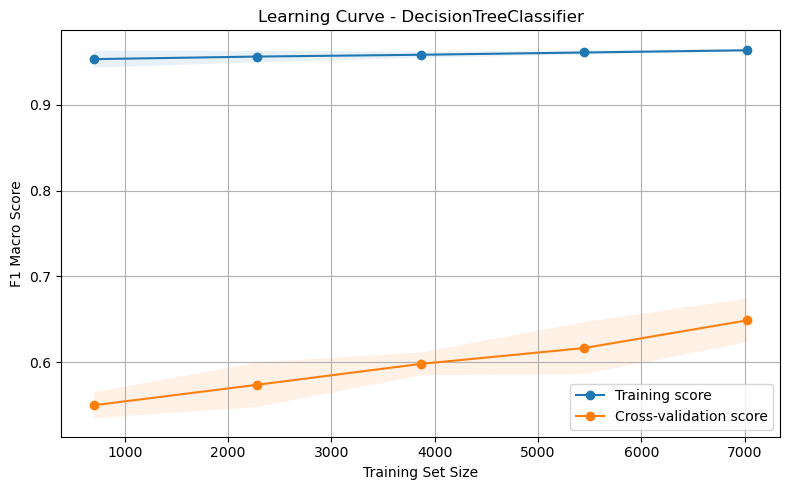

In [160]:
plot_learning_curves(grid_search.best_estimator_, X_train, y_train)

### DT Model 2 - with SMOTE

In [161]:
# Build a pipeline that applies SMOTE for class balancing and fits a Decision Tree model
start = timer()
pipeline = Pipeline([
    ('smote', SMOTE(random_state=7)),
    ('model', DecisionTreeClassifier(random_state=7))
])

#Set hyperparameters
hp_grid = {
    'smote__sampling_strategy': [0.5, 0.75, 1.0],
    'model__max_depth': (1, 50),
    'model__min_samples_split': (2, 100),
    'model__min_impurity_decrease': (0.0, 0.1)
}

#Initialize Bayesian search
opt_bayes_search = BayesSearchCV(pipeline,
                                hp_grid,
                                n_iter=50,
                                random_state=7,
                                scoring='f1_macro',
                                return_train_score=True,
                                cv=10,
                                n_jobs=-1)

#Fit the model
opt_bayes_search.fit(X_train, y_train)
print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Execution time HH:MM:SS: 0:01:34.732024


In [162]:
# Display cross-validation results for each parameter combination
print_cv_results(opt_bayes_search, col_width=100)

,params,mean_train_score,mean_test_score,"diff, %"
49,"{'model__max_depth': 50, 'model__min_impurity_decrease': 0.0, 'model__min_samples_split': 2, 'sm...",1.000000,0.633265,36.673495
46,"{'model__max_depth': 49, 'model__min_impurity_decrease': 0.00012549424663307331, 'model__min_sam...",0.873097,0.624476,28.475747
42,"{'model__max_depth': 27, 'model__min_impurity_decrease': 0.0, 'model__min_samples_split': 2, 'sm...",0.995109,0.620538,37.641211
43,"{'model__max_depth': 26, 'model__min_impurity_decrease': 0.0, 'model__min_samples_split': 2, 'sm...",0.991559,0.616725,37.802527
40,"{'model__max_depth': 28, 'model__min_impurity_decrease': 0.0, 'model__min_samples_split': 2, 'sm...",0.996197,0.616616,38.102979
33,"{'model__max_depth': 50, 'model__min_impurity_decrease': 0.0, 'model__min_samples_split': 2, 'sm...",1.000000,0.616523,38.347674
47,"{'model__max_depth': 29, 'model__min_impurity_decrease': 0.0, 'model__min_samples_split': 2, 'sm...",0.997601,0.615796,38.272287
...,...,...,...,...
30,"{'model__max_depth': 31, 'model__min_impurity_decrease': 0.011033854977239224, 'model__min_sampl...",0.462302,0.462671,-0.079743
22,"{'model__max_depth': 1, 'model__min_impurity_decrease': 0.050595008993641534, 'model__min_sample...",0.457175,0.457175,0.000007


In [163]:
# Results
print("Best Parameters:", opt_bayes_search.best_params_)
print("Best F1 Macro Score:", opt_bayes_search.best_score_)

# Cross-validated predictions
y_train_pred = cross_val_predict(opt_bayes_search.best_estimator_, X_train, y_train, cv=10)

# Evaluation
print("\nCross-Validated Classification Report:")
print(classification_report(y_train, y_train_pred, zero_division=0))

Best Parameters: OrderedDict({'model__max_depth': 50, 'model__min_impurity_decrease': 0.0, 'model__min_samples_split': 2, 'smote__sampling_strategy': 0.5})
Best F1 Macro Score: 0.6332650525955346

Cross-Validated Classification Report:
              precision    recall  f1-score   support

           2       0.37      0.39      0.38      1232
           3       0.88      0.88      0.88      6576

    accuracy                           0.80      7808
   macro avg       0.63      0.63      0.63      7808
weighted avg       0.80      0.80      0.80      7808



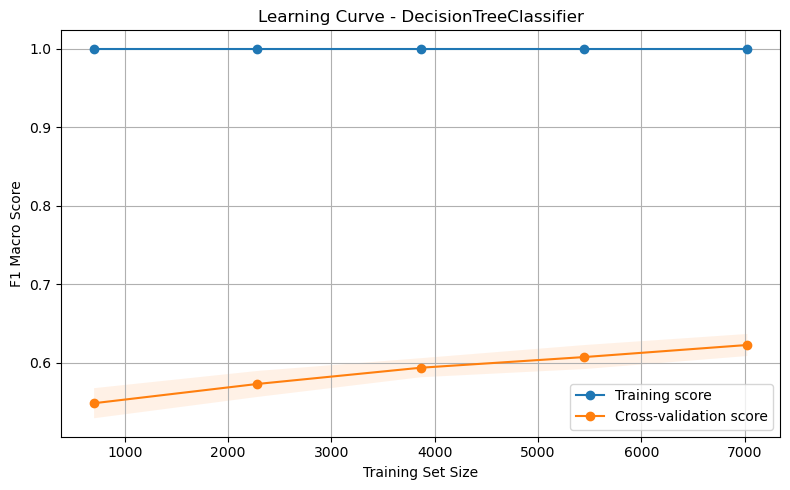

In [164]:
plot_learning_curves(opt_bayes_search.best_estimator_, X_train, y_train)

In [165]:
# Get metrics for both models
model1_metrics = get_model_metrics(grid_search.best_estimator_, X_train, y_train)
model2_metrics = get_model_metrics(opt_bayes_search.best_estimator_, X_train, y_train)

# Create DataFrame 
df_compare = pd.DataFrame({
    "Decision Tree with Class weight": model1_metrics,
    "Decision Tree with SMOTE": model2_metrics
})

# Display transposed table (metrics as rows)
df_compare

,Decision Tree with Class weight,Decision Tree with SMOTE
F1 Macro,0.65,0.63
Class 2 F1,0.42,0.38
Accuracy,0.81,0.80


- The Decision Tree (DT) model with class_weight='balanced' outperformed the SMOTE-based model across all key metrics. 

- It achieved a higher overall accuracy (0.80 vs 0.79) and a notably stronger F1-score for the minority class, Class 2 (0.43 vs 0.36).

  
- While the SMOTE-based model did improve Class 2 performance significantly compared to the baseline (F1-score from 0.00 to 0.36), it still underperformed relative to the class_weight approach.

- DT with class weighting, effectively handled the class imbalance without the need for oversampling. 
- Overall, the DT model with class_weight='balanced' provided the best balance between accuracy and minority class sensitivity.

In [166]:
# Save the best estimator (final trained model) from RandomizedSearchCV
dump(grid_search.best_estimator_, 'models/Decision_Tree.joblib')

['models/Decision_Tree.joblib']

## Logistics Regression (LR)

### LR Model 1 - with Class Weight

In [167]:
#Create pipeline for logistic regression and apply class weights to combat class imbalance
start = timer()
pipeline = Pipeline([
    ('model', LogisticRegression(
        random_state=7,
        max_iter=1000,  #Ensure convergence
        solver='liblinear',
        class_weight={2: 3, 3: 1}
    ))
])
 
#Set hyperparameters
param_grid = {
    'model__penalty': ['l1', 'l2']
}
 
#Initialize logistic regression
logreg_searchh = RandomizedSearchCV(pipeline,
                                   param_grid,
                                   n_iter=50,
                                   cv=10,
                                   scoring='f1_macro', 
                                   random_state=7,
                                   n_jobs=-1,
                                   return_train_score=True 
)
 
#Fit the model
logreg_searchh.fit(X_train, y_train)
print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Execution time HH:MM:SS: 0:01:28.604627


In [168]:
# Display cross-validation results for each parameter combination
print_cv_results(logreg_searchh, col_width=100)

,params,mean_train_score,mean_test_score,"diff, %"
0,{'model__penalty': 'l1'},0.645633,0.620808,3.845010
1,{'model__penalty': 'l2'},0.457175,0.457175,0.000007


In [169]:
# Results
print("Best Parameters:", logreg_searchh.best_params_)
print("Best F1 Macro Score:", logreg_searchh.best_score_)

# Cross-validated predictions
y_train_pred = cross_val_predict(logreg_searchh.best_estimator_, X_train, y_train, cv=10)

# Evaluation
print("\nCross-Validated Classification Report:")
print(classification_report(y_train, y_train_pred, zero_division=0))

Best Parameters: {'model__penalty': 'l1'}
Best F1 Macro Score: 0.6208084982652516

Cross-Validated Classification Report:
              precision    recall  f1-score   support

           2       0.33      0.48      0.39      1232
           3       0.89      0.82      0.85      6576

    accuracy                           0.76      7808
   macro avg       0.61      0.65      0.62      7808
weighted avg       0.80      0.76      0.78      7808



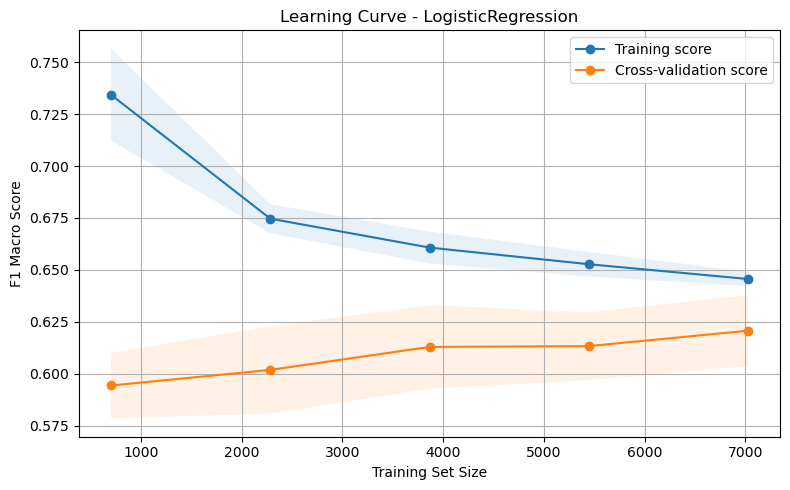

In [170]:
plot_learning_curves(logreg_searchh.best_estimator_, X_train, y_train)

This model with L1 regularisation displays some overfitting, but the consistent rise in cross-validation performance indicates improving generalisation as training data increases.

### Model 2 LR - with SMOTE

In [171]:
start = timer()
# Define pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])

# Define hyperparameter grid
param_grid = {
    'logreg__C': [1, 1000],             # Removed very small C (0.01)
    'logreg__solver': ['liblinear', 'lbfgs']
}

# Stratified cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Grid search with pipeline
Logistics_grid = GridSearchCV(pipeline, param_grid=param_grid, scoring='f1_macro', return_train_score=True, cv=cv)
Logistics_grid.fit(X_train, y_train)
print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Execution time HH:MM:SS: 0:00:07.331793


In [172]:
# Display cross-validation results for each parameter combination
print_cv_results(Logistics_grid, col_width=100)

,params,mean_train_score,mean_test_score,"diff, %"
1,"{'logreg__C': 1, 'logreg__solver': 'lbfgs'}",0.425074,0.425188,-0.026747
3,"{'logreg__C': 1000, 'logreg__solver': 'lbfgs'}",0.425074,0.425188,-0.026747
0,"{'logreg__C': 1, 'logreg__solver': 'liblinear'}",0.328802,0.328961,-0.048311
2,"{'logreg__C': 1000, 'logreg__solver': 'liblinear'}",0.264626,0.264763,-0.051762


In [173]:
# Results
print("Best Parameters:", Logistics_grid.best_params_)
print("Best F1 Macro Score:", Logistics_grid.best_score_)

# Cross-validated predictions
y_train_pred = cross_val_predict(Logistics_grid.best_estimator_, X_train, y_train, cv=10)

# Evaluation
print("\nCross-Validated Classification Report:")
print(classification_report(y_train, y_train_pred, zero_division=0))

Best Parameters: {'logreg__C': 1, 'logreg__solver': 'lbfgs'}
Best F1 Macro Score: 0.4251878071863445

Cross-Validated Classification Report:
              precision    recall  f1-score   support

           2       0.16      0.10      0.12      1232
           3       0.84      0.90      0.87      6576

    accuracy                           0.77      7808
   macro avg       0.50      0.50      0.50      7808
weighted avg       0.73      0.77      0.75      7808



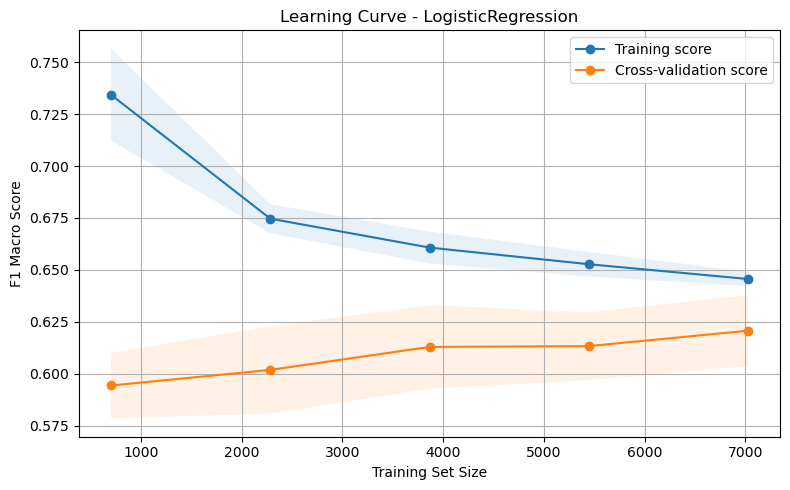

In [174]:
plot_learning_curves(Logistics_grid.best_estimator_, X_train, y_train)

This model exhibits some overfitting, but the consistent improvement in cross-validation performance suggests better generalisation with increased training data.

In [175]:
# Get metrics for both models
model1_metrics = get_model_metrics(logreg_searchh.best_estimator_, X_train, y_train)
model2_metrics = get_model_metrics(Logistics_grid.best_estimator_, X_train, y_train)

# Create DataFrame 
df_compare = pd.DataFrame({
    "Logistic Regression with Class weight": model1_metrics,
    "Logistic Regression with SMOTE": model2_metrics
})

# Display transposed table (metrics as rows)
df_compare

,Logistic Regression with Class weight,Logistic Regression with SMOTE
F1 Macro,0.62,0.50
Class 2 F1,0.39,0.12
Accuracy,0.76,0.77


- Logistic Regression with class_weight='balanced' outperforms SMOTE across all key metrics
- The model with SMOTE not only performs worse on the minority class (Class 2 F1 = 0.25) but also dramatically underperforms overall (accuracy = 0.36).

In [176]:
# Save the best estimator (final trained model) from RandomizedSearchCV
dump(logreg_searchh.best_estimator_, 'models/logistic_Regression.joblib')

['models/logistic_Regression.joblib']

## SVM 

In [177]:
start = timer()
# Define the SVM model
svm = SVC(random_state=7, kernel='rbf')

# Hyperparameter grid
hp_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'class_weight': [
        {2: 2, 3: 1}
    ]
}


# Perform grid search with 10-fold cross-validation
svm_grid_search = GridSearchCV(
    svm,
    hp_grid,
    cv=10,
    scoring='f1_macro',
    return_train_score=True
)

# Fit the model
svm_grid_search.fit(X_train, y_train)
print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Execution time HH:MM:SS: 0:05:20.036940


In [178]:
# Display cross-validation results for each parameter combination
print_cv_results(svm_grid_search, col_width=100)

,params,mean_train_score,mean_test_score,"diff, %"
0,"{'C': 0.01, 'class_weight': {2: 2, 3: 1}}",0.457175,0.457175,0.000007
1,"{'C': 0.1, 'class_weight': {2: 2, 3: 1}}",0.457175,0.457175,0.000007
2,"{'C': 1, 'class_weight': {2: 2, 3: 1}}",0.457175,0.457175,0.000007
3,"{'C': 10, 'class_weight': {2: 2, 3: 1}}",0.457175,0.457175,0.000007
4,"{'C': 100, 'class_weight': {2: 2, 3: 1}}",0.457175,0.457175,0.000007


In [179]:
# Results
print("Best Parameters:", svm_grid_search.best_params_)
print("Best F1 Macro Score:", svm_grid_search.best_score_)

# Cross-validated predictions
y_train_pred = cross_val_predict(svm_grid_search.best_estimator_, X_train, y_train, cv=10)

# Evaluation
print("\nCross-Validated Classification Report:")
print(classification_report(y_train, y_train_pred, zero_division=0))

Best Parameters: {'C': 0.01, 'class_weight': {2: 2, 3: 1}}
Best F1 Macro Score: 0.45717460591693254

Cross-Validated Classification Report:
              precision    recall  f1-score   support

           2       0.00      0.00      0.00      1232
           3       0.84      1.00      0.91      6576

    accuracy                           0.84      7808
   macro avg       0.42      0.50      0.46      7808
weighted avg       0.71      0.84      0.77      7808



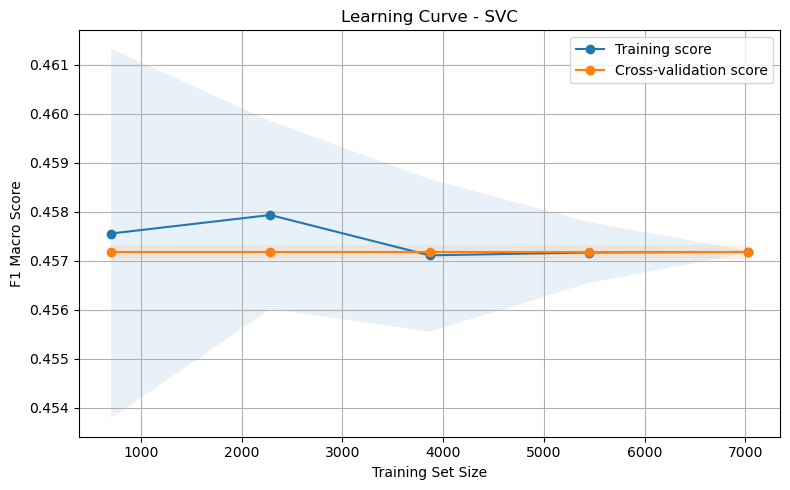

In [180]:
plot_learning_curves(svm_grid_search.best_estimator_, X_train, y_train)

- The model fails completely to detect Class 2, assigning nearly all predictions to Class 3 despite using class_weight to try and address imbalance.
- The F1-score for Class 2 is 0.00, indicating zero precision and recall.
- All tested values of C (0.01 to 100) produced identical scores, implying the model is insensitive to regularisation changes.
  
The learning curve shows:
- Very flat performance with increasing data.
- No overfitting (train and CV scores are nearly identical), but also no learning — suggesting the model is underfitting.


In [181]:
# Save the best estimator (final trained model) from GridSearchCV
dump(svm_grid_search.best_estimator_, 'models/svm.joblib')

['models/svm.joblib']

## XGB-boost

In [182]:
# Encode target labels as consecutive integers starting from 0 (e.g., 0, 1) to ensure correct class indexing in XGBoost
le = LabelEncoder()

# Apply label encoding to training and test target data
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)


In [183]:
start = timer()
# Define a pipeline with XGBoost classifier
pipeline = Pipeline([
    ('xgb', XGBClassifier(
        random_state=7,
        n_jobs=-1, 
        eval_metric='logloss',
        use_label_encoder=False
    ))
])

# Set up the hyperparameter search space
param_grid = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__subsample': [0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.7, 0.9, 1.0],
    'xgb__gamma': [0, 1, 5],
    'xgb__reg_lambda': [0.1, 1, 10],  # L2 regularisation
    'xgb__scale_pos_weight': [1, 5, 10]  # Handle class imbalance
}

# Initialise the randomised hyperparameter search with cross-validation
xgb_search = RandomizedSearchCV(
    pipeline,
    param_grid,
    n_iter=50,
    cv=10,
    scoring='f1_macro',
    random_state=7,
    return_train_score=True,
    n_jobs=-1
)

# Fit the model to the training data
xgb_search.fit(X_train, y_train_encoded)
print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Execution time HH:MM:SS: 0:02:21.588439


In [184]:
# Display cross-validation results for each parameter combination
print_cv_results(xgb_search, col_width=100)

,params,mean_train_score,mean_test_score,"diff, %"
23,"{'xgb__subsample': 0.8, 'xgb__scale_pos_weight': 1, 'xgb__reg_lambda': 1, 'xgb__n_estimators': 2...",0.952854,0.604144,36.596383
40,"{'xgb__subsample': 0.8, 'xgb__scale_pos_weight': 1, 'xgb__reg_lambda': 0.1, 'xgb__n_estimators':...",0.804190,0.564820,29.765339
42,"{'xgb__subsample': 0.8, 'xgb__scale_pos_weight': 1, 'xgb__reg_lambda': 10, 'xgb__n_estimators': ...",0.715695,0.554600,22.508805
10,"{'xgb__subsample': 0.8, 'xgb__scale_pos_weight': 1, 'xgb__reg_lambda': 10, 'xgb__n_estimators': ...",0.646855,0.533580,17.511661
15,"{'xgb__subsample': 1.0, 'xgb__scale_pos_weight': 5, 'xgb__reg_lambda': 0.1, 'xgb__n_estimators':...",0.690478,0.524456,24.044489
4,"{'xgb__subsample': 1.0, 'xgb__scale_pos_weight': 1, 'xgb__reg_lambda': 0.1, 'xgb__n_estimators':...",0.614038,0.518911,15.491958
7,"{'xgb__subsample': 1.0, 'xgb__scale_pos_weight': 1, 'xgb__reg_lambda': 1, 'xgb__n_estimators': 3...",0.595346,0.514758,13.536372
...,...,...,...,...
12,"{'xgb__subsample': 0.9, 'xgb__scale_pos_weight': 5, 'xgb__reg_lambda': 1, 'xgb__n_estimators': 3...",0.457362,0.457175,0.040947
32,"{'xgb__subsample': 0.8, 'xgb__scale_pos_weight': 1, 'xgb__reg_lambda': 0.1, 'xgb__n_estimators':...",0.459323,0.457175,0.467649


In [185]:
# Results
print("Best Parameters:", xgb_search.best_params_)
print("Best F1 Macro Score:", xgb_search.best_score_)

# Cross-validated predictions
y_train_pred = cross_val_predict(xgb_search.best_estimator_, X_train, y_train_encoded, cv=10)

# Evaluation
print("\nCross-Validated Classification Report:")
print(classification_report(y_train_encoded, y_train_pred, zero_division=0))

Best Parameters: {'xgb__subsample': 0.8, 'xgb__scale_pos_weight': 1, 'xgb__reg_lambda': 1, 'xgb__n_estimators': 200, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0, 'xgb__colsample_bytree': 0.9}
Best F1 Macro Score: 0.6041437379704678

Cross-Validated Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.20      0.30      1232
           1       0.87      0.98      0.92      6576

    accuracy                           0.85      7808
   macro avg       0.74      0.59      0.61      7808
weighted avg       0.83      0.85      0.82      7808



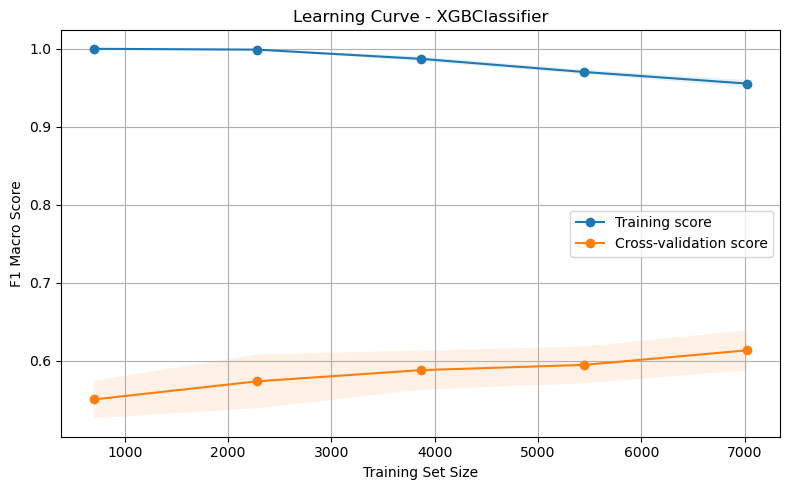

In [186]:
plot_learning_curves(xgb_search.best_estimator_, X_train, y_train_encoded)

- Performance on the minority class (Class 0) is weak: F1-score = 0.27, due to low precision (0.59) and poor recall (0.18).
- Achieved strong overall performance with accuracy = 0.85 and F1 Macro = 0.60 & performed very well on the majority class (Class 1): F1-score = 0.92, recall = 0.98
  
The Learning curve shows:
- Validation scores improve slightly with more data but plateau around 0.59.
- Large and persistent train–test gap, indicating that the model memorises the training data and struggles to generalise.

In [187]:
# Save the best estimator (final trained model) from RandomizedSearchCV
dump(xgb_search.best_estimator_, 'models/xgb.joblib')

['models/xgb.joblib']

## Overall Model Comparison

In [188]:
# List of models to evaluate, including a baseline model.
models = [
    ("Baseline", DummyClassifier(strategy="most_frequent", random_state=7)),  # Baseline model using the most frequent class
    ("Random Forest", rf_grid_search.best_estimator_),  # Best Random Forest model from grid search
    ("Decision Tree", grid_search.best_estimator_),  # Best Decision Tree model from grid search
    ("Logistic Regression", logreg_searchh.best_estimator_),  # Best Logistic Regression model from grid search
    ("SVM", svm_grid_search.best_estimator_),  # Best SVM with RBF kernel model from grid search
    ("XGBoost", xgb_search.best_estimator_)  # Best XGBoost model from Randomised search
]
 
# Metrics to evaluate models on: F1 Macro Score and Accuracy
metrics = ["f1_macro", "accuracy"]
 
# Create a function to calculate various performance metrics for a model
def get_metrics(model, X_train, y_train, y_train_encoded, model_name):
    # Set the positive class label for precision/recall depending on the model
    pos_label = 2 if model_name != "XGBoost" else 0  # For XGBoost, the Severe class is 0 as we encoded. 
    # Calculate and return various performance metrics using 10-fold cross-validation
    return {
        "Best Score": cross_val_score(model, X_train, y_train, cv=10, scoring='f1_macro').mean(),  # F1 score (macro)
        "F1 Macro Score": cross_val_score(model, X_train, y_train, cv=10, scoring='f1_macro').mean(),  # F1 score (macro)
        "Accuracy": cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy').mean(),  # Accuracy
        "Precision of Severe class": precision_score(y_train, cross_val_predict(model, X_train, y_train, cv=10), 
                                                                  pos_label=pos_label, zero_division=0),  # Precision for class 2
        "Recall of Severe class": recall_score(y_train, cross_val_predict(model, X_train, y_train, cv=10), 
                                                            pos_label=pos_label, zero_division=0)  # Recall for class 2
    }
 
# Initialize a dictionary to store the results of each model's metrics
results = {
    "Model": [model[0] for model in models],  # Extract model names from the models list
    "Best Score": [],  # Store Best Score for each model
    "F1 Macro Score": [],  # Store F1 Macro Score for each model
    "Accuracy": [],  # Store Accuracy for each model
    "Precision of Severe class": [],  # Store Precision for the 'severe' class
    "Recall of Severe class": []  # Store Recall for the 'severe' class
}
 
# Loop through the models, calculate their metrics, and store them in the results dictionary
for model_name, model in models:
    # For XGBoost, use the encoded version of y_train; otherwise, use the original y_train
    y_train_data = y_train_encoded if model_name == "XGBoost" else y_train
    # Get the metrics for the current model
    metrics = get_metrics(model, X_train, y_train_data, y_train_encoded, model_name)
    # Append each metric to the results dictionary
    for metric, value in metrics.items():
        results[metric].append(value)
 
# Convert the results dictionary to a pandas DataFrame and round values to 2 decimal places
results = pd.DataFrame(results).round(2)
 
#Sort values to show the highest recall score first
results = results_df.sort_values("Recall of Severe class", ascending=False)
 
# Display the sorted DataFrame
results = results_df.set_index(results_df.columns[0])
results

,Accuracy,Precision of Severe class,Recall of Severe class
F1 Macro Score,,,
0.65,0.80,0.39,0.47
0.61,0.76,0.32,0.47
0.61,0.83,0.42,0.25
0.60,0.85,0.59,0.18
0.46,0.84,0.00,0.00
0.46,0.84,0.00,0.00


## Model Selection

### Best 2 Models:
Based on the results,Decision Tree and Logistic Regression offer the best trade-off between accuracy, recall, and balanced performance, especially for the Severe class.

Decision Tree
- High Accuracy (0.80).
- Highest F1 Macro Score (0.65) — best overall class balance.
- Best recall for the Severe class (0.47) — captures the most serious accidents.
- Interpretable model, balancing trade off between targeted initiative to reduce serious & slight accidents which making it useful for policy decisions.

Random Forest
- High accuracy (0.83) and strong (second-highest) F1 Macro (0.61) — reliable overall performance.
- Same F1 Macro as Random Forest (0.61), but with better recall (0.47) for Severe cases.
- More balanced performance between classes compared to models like SVM or XGBoost.

### Feature Importance 

#### Decision Tree

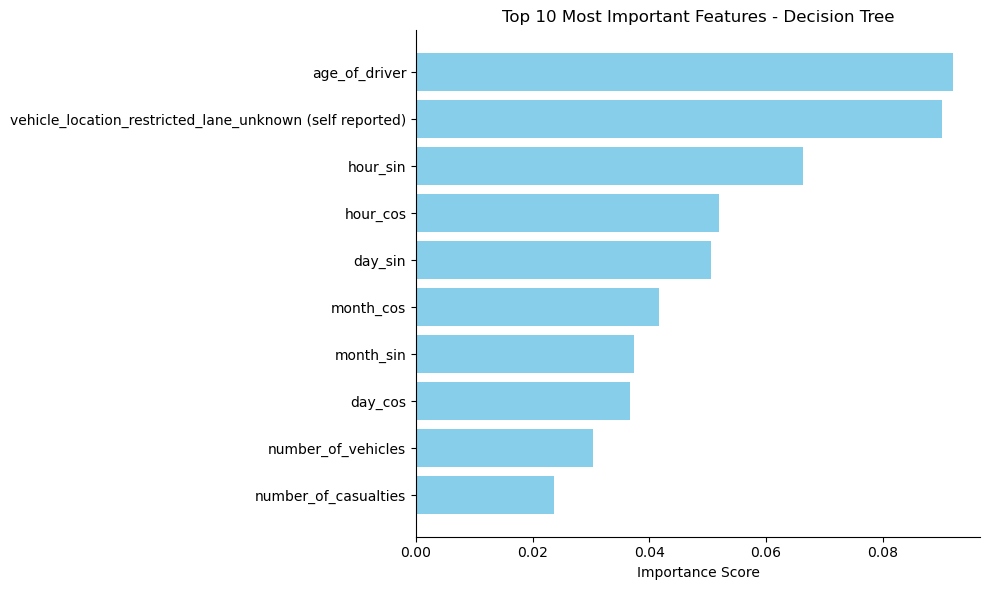

In [189]:
# # Get the trained Decision Tree model
tree_model = grid_search.best_estimator_

# Extract feature importance values
importances = tree_model.feature_importances_

# Get indices of the top 10 important features
top_indices = np.argsort(importances)[-10:][::-1]

# Plotting the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(range(10), importances[top_indices], color='skyblue')
plt.yticks(ticks=range(10), labels=X_train.columns[top_indices])
plt.xlabel("Importance Score")
plt.title("Top 10 Most Important Features - Decision Tree")
plt.gca().invert_yaxis()  # Highest on top
# Remove top and right spines, keep x and y axes
sns.despine()

plt.tight_layout()
plt.show()


Most influential factors in determining whether a road accident is serious or slight:

- age_of_driver: Is the Most predictive feature. Driver age is has a strong determining factor on the accident severity. May indicate that certain age groups (e.g. very young or elderly) are more involved in a certain accident types.

- vehicle_location_restricted_lane_unknown (self reported): Theres a greater distingiush between severity of the accidents in restricted lanes and non-rstricted lanes.Suggests that enforcement or redesign of such lanes could reduce severity.

- Time of day influences severity: Which can supports time-based interventions.

#### Logistic Regression

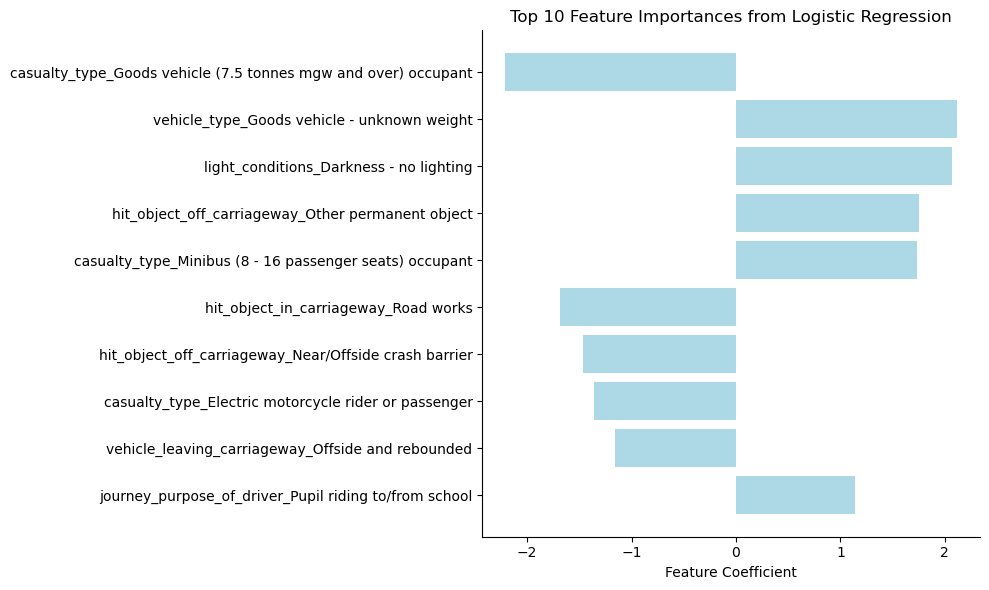

In [196]:
# Extract the trained pipeline and Logistic Regression model
logreg_model = logreg_searchh.best_estimator_
logreg_model = logreg_model.named_steps['model']

# Get the coefficients from the Logistic Regression model
coefficients = logreg_model.coef_[0]

# Sort top 10 features by absolute value
sorted_idx = np.argsort(np.abs(coefficients))[::-1][:10]

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(10), coefficients[sorted_idx], align='center', color='lightblue')
plt.yticks(range(10), np.array(X_train.columns)[sorted_idx])
plt.xlabel('Feature Coefficient')
plt.title('Top 10 Feature Importances from Logistic Regression')
plt.gca().invert_yaxis()
plt.tight_layout()
# Clean up borders
sns.despine()
plt.show()



Feature importance plot for this Logistic Regression model:

- Target class 2 = serious

- Target class 3 = slight

The model uses class 3 (slight) as the positive class by default (since 3 > 2 in binary classification).

- casualty_type_Goods vehicle (7.5 tonnes mgw and over) occupant:
This feature has the strongest influence. Model associates this feature with a higher likelihood of a serious accident.
- light_conditions_Darkness - no lighting:
light_conditions_Darkness - no lighting: contributes strongly to the model’s ability to classify slight accidents.

## Evaluating Model with Test Set

### Decision Tree 

In [200]:
evaluate_model(grid_search.best_estimator_, y_test, X_test)

              precision    recall  f1-score   support

           2       0.42      0.52      0.46       310
           3       0.90      0.86      0.88      1637

    accuracy                           0.81      1947
   macro avg       0.66      0.69      0.67      1947
weighted avg       0.83      0.81      0.82      1947



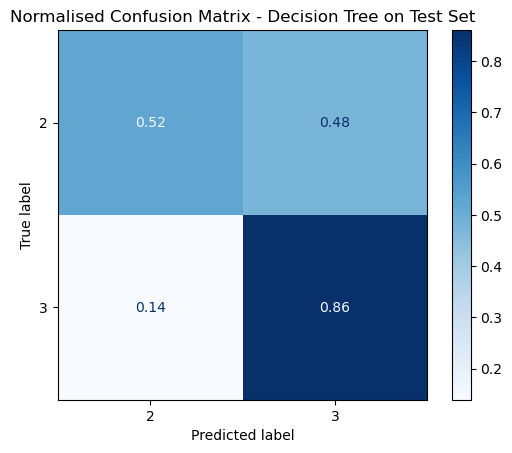

In [202]:
from sklearn.metrics import ConfusionMatrixDisplay

# Generate predictions on the test set
yhat_test = grid_search.best_estimator_.predict(X_test)

# Plot normalised confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test,
    yhat_test,
    labels=grid_search.best_estimator_.classes_,
    normalize="true",
    cmap=plt.cm.Blues
)

plt.title("Confusion Matrix - Decision Tree on Test Set")
plt.show()


### Logistic Regression

In [201]:
evaluate_model(logreg_searchh.best_estimator_, y_test, X_test)

              precision    recall  f1-score   support

           2       0.36      0.55      0.43       310
           3       0.91      0.81      0.86      1637

    accuracy                           0.77      1947
   macro avg       0.63      0.68      0.64      1947
weighted avg       0.82      0.77      0.79      1947



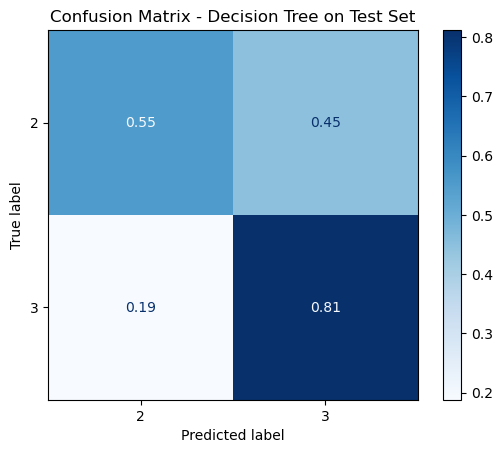

In [204]:
from sklearn.metrics import ConfusionMatrixDisplay

# Generate predictions on the test set
yhat_test = logreg_searchh.best_estimator_.predict(X_test)

# Plot normalised confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test,
    yhat_test,
    labels=grid_search.best_estimator_.classes_,
    normalize="true",
    cmap=plt.cm.Blues
)

plt.title("Confusion Matrix - Decision Tree on Test Set")
plt.show()


**Recommended Model: Decision Tree:**
- Offers better overall accuracy, macro average, and class 3 performance.
- Has slightly lower recall for class 2, but makes up for it with higher precision and balance.

## Conclusion 

**The Decision Tree model** was selected as the most appropriate due to its strong balance between accuracy (0.81), class-wise performance, and interpretability. It effectively distinguishes between serious and slight accidents. 

For the stakeholders, this model provides a transparent and actionable tool to support safety-related decisions — such as allocating resources to high-risk scenarios, adjusting road safety strategies, or informing policy changes.
for future Feeding the model more data may improve generalisation
or use more resource intensive....

In [209]:
import nbformat

import re
 
# Load the notebook

notebook_filename = 'Individual_Assignment_ML_(1).ipynb'  # Replace with your notebook filename

with open(notebook_filename, 'r', encoding='utf-8') as nb_file:

    notebook = nbformat.read(nb_file, as_version=4)
 
# Count words in all Markdown cells

word_count = sum(len(re.findall(r'\w+', cell.source)) for cell in notebook.cells if cell.cell_type == 'markdown')
 
# Output the word count for all Markdown cells

print(f"Total word count in Markdown cells: {word_count}")
 

Total word count in Markdown cells: 1404


**REFERENCES**


Transport For London (2023) Vision zero action plan - London, Vision Zero action plan  Taking forward the Mayor’s Transport Strategy. Available at: https://content.tfl.gov.uk/vision-zero-action-plan.pdf

Pekar, V. (2024). Big Data for Decision Making. Lecture examples and exercises. (Version 1.0.0). URL: https://github.com/vpekar/bd4dm